**Notebook display settings**

This cell enables inline charts and sets table display settings

In [12]:
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

import pandas as pd
pd.options.display.max_columns = 10
pd.options.display.max_rows = 30

**Importing the MIMIC `session` module**

The `session` module provides the ability to log in for easy access to the  MIMIC database. Once logged in, the rest of the library just works.

Another ability provided by `session` is to enable local storage. Once enabled, this will cause `chatto-transform` to store the results of all queries it makes to the mimic database on the filesystem. Then, if the same queries are requested again later, they'll be loaded into the program without connecting to the remote database. Loading from local storage is about 10 times faster than going to the database.

In [2]:
from chatto_transform.lib.mimic import session

session.login()
session.enable_local_storage('/Users/dan/dev/data/mimic')

**Importing pre-defined transforms**

The two transforms **AgeTransform** and **AgeHistTransform** capture this query from the MIMIC cookbook:

```
select bucket+15, count(*) from (
    select
        months_between(ad.admit_dt, dp.dob)/12,
        width_bucket(months_between(ad.admit_dt, dp.dob)/12, 15, 100, 85) as bucket
    from
        mimic2v26.admissions ad,
        mimic2v26.d_patients dp
    where
        ad.subject_id = dp.subject_id
        and months_between(ad.admit_dt, dp.dob)/12 between 15 and 199
) sub
group by bucket
order by bucket;
```

In [3]:
from chatto_transform.transforms.mimic.age_transform import AgeTransform, AgeHistTransform

In [4]:
# load the tables 'admissions' and 'd_patients' and merges them
age_df = AgeTransform().load_transform()

In [5]:
age_df

,admissions.hadm_id,admissions.subject_id,admissions.admit_dt,admissions.disch_dt,d_patients.subject_id,d_patients.sex,d_patients.dob,d_patients.dod,d_patients.hospital_expire_flg,age_at_admission
1,2075,3,2682-09-07 00:00:00,2682-09-18 00:00:00,3,M,2606-02-28 00:00:00,2683-05-02 00:00:00,N,76
2,17296,4,3399-04-03 00:00:00,3399-04-10 00:00:00,4,F,3351-05-30 00:00:00,NaN,N,47
4,23467,6,3389-07-07 00:00:00,3389-07-23 00:00:00,6,F,3323-07-30 00:00:00,NaN,N,65
7,8253,9,2984-12-12 00:00:00,2984-12-17 00:00:00,9,M,2943-02-28 00:00:00,2984-12-17 00:00:00,Y,41
9,28128,11,2648-05-04 00:00:00,2648-05-29 00:00:00,11,F,2598-03-11 00:00:00,2648-12-02 00:00:00,N,50
...,...,...,...,...,...,...,...,...,...,...
36055,32053,32804,3433-12-22 00:00:00,3434-01-13 00:00:00,32804,M,3354-04-26 00:00:00,NaN,N,79
36056,34884,32805,2986-11-16 00:00:00,2986-12-28 00:00:00,32805,M,2920-12-13 00:00:00,NaN,N,65
36058,32736,32807,2594-10-08 00:00:00,2594-10-14 00:00:00,32807,M,2513-10-04 00:00:00,NaN,N,81
36059,34401,32808,2888-07-15 00:00:00,2888-07-16 00:00:00,32808,F,2840-05-14 00:00:00,NaN,N,48


**Creating a histogram of age at admission**


The functionality for creating this histogram is wrapped up in the AgeHistTransform class, but it's quite simple. Pass in a DataFrame with an 'age_at_admission' column, get out a histogram.

In [6]:
age_count_df = AgeHistTransform().transform(age_df)

In [7]:
age_count_df

,count
15,9
16,20
17,50
18,102
19,110
...,...
96,37
97,14
98,21
99,14


**Plot the histogram**


(Axes need work...)

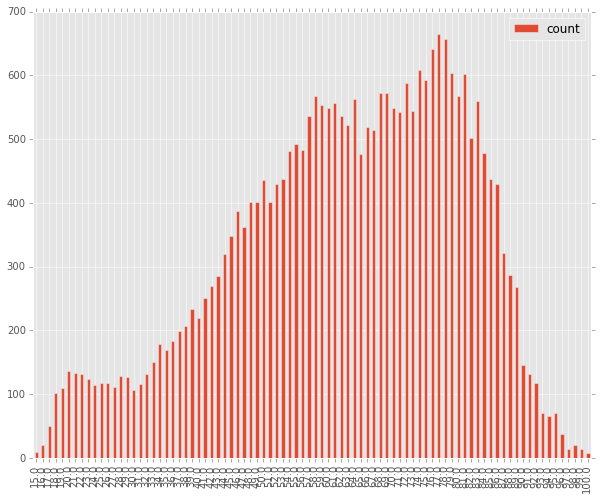

In [8]:
age_count_df.plot(kind='bar')

**Importing the Blood Urea Nitrogen transform**

Capturing the 'bun' recipe from the MIMIC cookbook:

```
select bucket, count(*) from (
  select width_bucket(valuenum, 0, 280, 280) as bucket
    from mimic2v26.labevents le,
         mimic2v26.d_patients dp
   where itemid in (50177)
     and le.subject_id = dp.subject_id
     and months_between(le.charttime, dp.dob)/12 > 15
  ) group by bucket order by bucket;
```

In [9]:
from chatto_transform.transforms.mimic.bun_transform import BUNTransform, BUNHistTransform

Loading a subset of the large table, **labevents**. This table has over 10 million rows, but the subset we're selecting (BUN tests) is about 500k. Because we have enabled **local storage**, this query takes a bit under 2 minutes to run the first time, and about 7 seconds every time thereafter.

In [10]:
bun_df = BUNTransform().load_transform()

Scrolling to the right side of this table reveals that in addition to joining the **labevents** and **d_patients** columns, we have also computed 2 new columns: "age_at_labevent" and "bun".

See the code in `chatto_transform/transforms/mimic/bun_transform.py` to get a sense of what computing those extra columns looks like.

In [11]:
bun_df

,labevents.subject_id,labevents.hadm_id,labevents.icustay_id,labevents.itemid,labevents.charttime,...,d_patients.dob,d_patients.dod,d_patients.hospital_expire_flg,age_at_labevent,bun
0,3,NaN,NaN,50177,2682-08-22 16:24:00,...,2606-02-28 00:00:00,2683-05-02 00:00:00,N,76,42
1,3,NaN,NaN,50177,2682-08-23 07:00:00,...,2606-02-28 00:00:00,2683-05-02 00:00:00,N,76,35
2,3,NaN,NaN,50177,2682-08-24 06:45:00,...,2606-02-28 00:00:00,2683-05-02 00:00:00,N,76,32
3,3,NaN,NaN,50177,2682-08-25 05:30:00,...,2606-02-28 00:00:00,2683-05-02 00:00:00,N,76,31
4,3,NaN,NaN,50177,2682-08-29 20:10:00,...,2606-02-28 00:00:00,2683-05-02 00:00:00,N,76,42
...,...,...,...,...,...,...,...,...,...,...,...
521643,32809,NaN,NaN,50177,3420-11-13 16:00:00,...,3348-05-02 00:00:00,NaN,N,72,17
521644,32809,NaN,NaN,50177,3420-11-14 05:50:00,...,3348-05-02 00:00:00,NaN,N,72,17
521645,32809,NaN,NaN,50177,3421-08-01 10:00:00,...,3348-05-02 00:00:00,NaN,N,73,37
521646,32809,NaN,NaN,50177,3422-02-15 09:20:00,...,3348-05-02 00:00:00,NaN,N,73,47


Now we use the `BUNHistTransform` to get a histogram of BUN levels across all lab tests available in the database.

In [12]:
bun_count_df = BUNHistTransform().transform(bun_df)

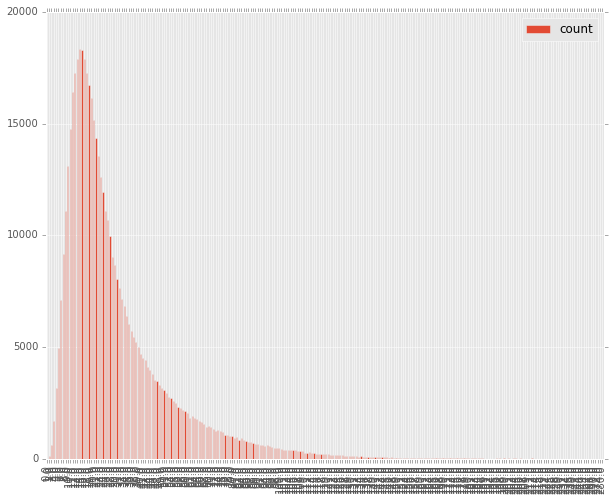

In [13]:
bun_count_df.plot(kind='bar')

We now examine the relationship between `age_at_labevent` and `bun`, and show the results in a another chart.

In [14]:
age_vs_mean = bun_df.groupby('age_at_labevent')['bun'].mean()

In [15]:
age_vs_mean

age_at_labevent
15     12.413043
16     10.021583
17     14.167095
18     13.194067
19     12.980930
         ...    
203    23.642857
204    22.925926
205    26.384615
206    24.818182
207    22.388889
Name: bun, dtype: float64

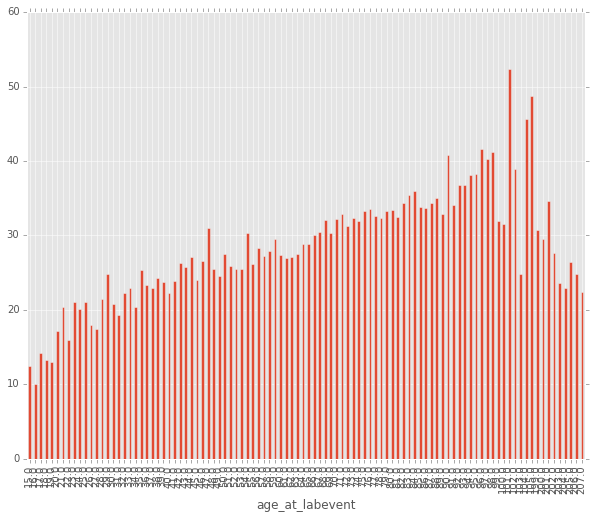

In [16]:
age_vs_mean.plot(kind='bar')

**Loading raw tables**

Here we demonstrate how to load the contents of mimic tables without using transforms. To start, we import the `mimic_schema` module. It contains information about all the tables in the mimic database.

In [3]:
from chatto_transform.lib.mimic.session import load_table, store_csv
from chatto_transform.schema.mimic import mimic_schema

You can inspect the schemas for each table in the database. In this representation, you can see the types of each column in the `d_patients` table.

In [4]:
mimic_schema.d_patients_schema

Schema("d_patients", [
    id_("subject_id"),
    cat("sex"),
    big_dt("dob"),
    big_dt("dod"),
    cat("hospital_expire_flg")
],
options={
    'db_schema': 'mimic2v26'
})

Now we use `load_table` to load the d_patients table. Because local storage is enabled, all tables loaded from the database are stored locally for later use.

In [20]:
d_patients = load_table(mimic_schema.d_patients_schema)

In [21]:
d_patients

,subject_id,sex,dob,dod,hospital_expire_flg
0,1,F,2840-08-10 00:00:00,NaN,N
1,2,M,2806-06-15 00:00:00,NaN,N
2,3,M,2606-02-28 00:00:00,2683-05-02 00:00:00,N
3,4,F,3351-05-30 00:00:00,NaN,N
4,5,M,2579-04-09 00:00:00,NaN,N
...,...,...,...,...,...
32498,32805,M,2920-12-13 00:00:00,NaN,N
32499,32806,M,2712-08-30 00:00:00,NaN,N
32500,32807,M,2513-10-04 00:00:00,NaN,N
32501,32808,F,2840-05-14 00:00:00,NaN,N


Now let's load blood urea nitrogen information. This data is stored in the `labevents` table, with `itemid` equal to 50177.

In [23]:
labevents_schema = mimic_schema.labevents_schema
labevents_schema

Schema("labevents", [
    id_("subject_id"),
    id_("hadm_id"),
    id_("icustay_id"),
    id_("itemid"),
    big_dt("charttime"),
    cat("value"),
    num("valuenum"),
    cat("flag"),
    cat("valueuom")
],
options={
    'db_schema': 'mimic2v26'
})

Rather than load the full `labevents` table, we can load just the subset that we want, by passing a condition string to the call to `load_table`:

In [24]:
bun_labevents = load_table(labevents_schema, "itemid=50177")

(A note about condition strings- you can write anything here that would go in the WHERE clause of a SQL query, including using AND and OR to combine multiple conditions.)

In [25]:
bun_labevents

,subject_id,hadm_id,icustay_id,itemid,charttime,value,valuenum,flag,valueuom
0,3,NaN,NaN,50177,2682-08-22 16:24:00,42,42,abnormal,mg/dL
1,3,NaN,NaN,50177,2682-08-23 07:00:00,35,35,abnormal,mg/dL
2,3,NaN,NaN,50177,2682-08-24 06:45:00,32,32,abnormal,mg/dL
3,3,NaN,NaN,50177,2682-08-25 05:30:00,31,31,abnormal,mg/dL
4,3,NaN,NaN,50177,2682-08-29 20:10:00,42,42,abnormal,mg/dL
...,...,...,...,...,...,...,...,...,...
521643,32809,NaN,NaN,50177,3420-11-13 16:00:00,17,17,nan,mg/dL
521644,32809,NaN,NaN,50177,3420-11-14 05:50:00,17,17,nan,mg/dL
521645,32809,NaN,NaN,50177,3421-08-01 10:00:00,37,37,abnormal,mg/dL
521646,32809,NaN,NaN,50177,3422-02-15 09:20:00,47,47,abnormal,mg/dL


In [5]:
store_csv('/Users/dan/dev/data/d_patients.csv', mimic_schema.d_patients_schema)

In [6]:
!head /Users/dan/dev/data/d_patients.csv

subject_id,sex,dob,dod,hospital_expire_flg
1,F,2840-08-10 00:00:00,,N
2,M,2806-06-15 00:00:00,,N
3,M,2606-02-28 00:00:00,2683-05-02 00:00:00,N
4,F,3351-05-30 00:00:00,,N
5,M,2579-04-09 00:00:00,,N
6,F,3323-07-30 00:00:00,,N
7,F,2666-06-22 00:00:00,,N
8,M,2854-01-10 00:00:00,,N
9,M,2943-02-28 00:00:00,2984-12-17 00:00:00,Y


In [4]:
icustay_detail = load_table(mimic_schema.icustay_detail_schema)

In [5]:
from chatto_transform.transforms.mimic import patient_history_transform

In [6]:
dt = patient_history_transform.DemographicTransform()

In [8]:
demo_info = dt.transform(icustay_detail)

In [13]:
demo_info.head(20)

,subject_id,charttime,category,valuenum
0,1,2896-10-10 00:41:00,AGE,56
1,1,2896-10-10 00:41:00,GENDER,0
2,1,2896-10-10 00:41:00,LOS,NaN
3,1,2896-10-10 00:41:00,SURVIVAL,NaN
4,1,2896-10-10 00:41:00,WEIGHT,NaN
5,1,2896-10-10 00:41:00,HEIGHT,NaN
6,1,2896-10-10 00:41:00,SAPS,NaN
7,1,2896-10-10 00:41:00,SOFA,NaN
8,1,2896-10-24 11:42:00,AGE,56
9,1,2896-10-24 11:42:00,GENDER,0
